<a href="https://colab.research.google.com/github/Stephen-Data-Engineer-Public/Full-Stack-Data-Analysis/blob/main/Data_Extraction_and_anaylsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import sqlite3
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# connecting to Sqlite database
conn = sqlite3.connect('movie_data.db')
cursor = conn.cursor()

# Extracting and Loading Data Into the SQLite Database

In [3]:
def read_data_to_sql(url, table_name, conn):
    if url.endswith('.csv'):
        df = pd.read_csv(url)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
    elif url.endswith('.tsv'):
        df = pd.read_csv(url, delimiter='\t')
        df.to_sql(table_name, conn, if_exists='replace', index=False)

def extract_tables_to_sql():
    conn = sqlite3.connect('movie_data.db')

    tables = {
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/MovieLens_movies.csv": "movies_Id",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/IMDb%20BoxOfficeMojo%20-%20Brands%20(US%20%26%20Canada).tsv": "brands_US_and_Canada",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/IMDb%20BoxOfficeMojo%20-%20Brand_%20Marvel%20Comics.tsv": "brand_marvel_comics",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/The%20Numbers%20-%20Domestic%20Box%20Office%20Daily%20-%20The%20Avengers.tsv": "Domestic_Box_Office_Daily_The_Avengers",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/The%20Numbers%20-%20Domestic%20Box%20Office%20-%20Franchises.tsv": "Domestic_Box_Office_Franchises",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/The%20Numbers%20-%20Domestic%20Box%20Office%20-%20Franchises%20-%20Marvel%20Cinematic%20Universe.tsv": "Domestic_Box_Office_Franchises_Marvel_Cinematic",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/World%20Wide%20Box%20Office%20All%20Time%20Top%201000.tsv": "World_Wide_Box_Office_All_Time_Top_1000",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/IMDb%20BoxOfficeMojo%20-%20Franchises%20(US%20%26%20Canada).tsv": "Franchises_us_and_Canada",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/IMDb%20BoxOfficeMojo%20-%20Franchise_%20top20.tsv": "top_20_for_each_Franchise",
        "https://raw.githubusercontent.com/mansik95/IMDB-Analysis/master/Data/MovieLens_tags.csv": "tags"

    }

    for url, table_name in tables.items():
        read_data_to_sql(url, table_name, conn)

    #conn.close()

# Call the function to extract tables to SQLite
extract_tables_to_sql()


# Ranking The Top 20 franchise based on Gross Revenue

In [65]:
cursor.execute('''
SELECT franchise, CAST(REPLACE(REPLACE(Worldwide_Box_office, '$', ''), ',', '') AS INTEGER) AS Worldwide_Box_office_cleaned
FROM Domestic_Box_Office_Franchises
Order by 2 DESC
LIMIT 20''')
results = cursor.fetchall()

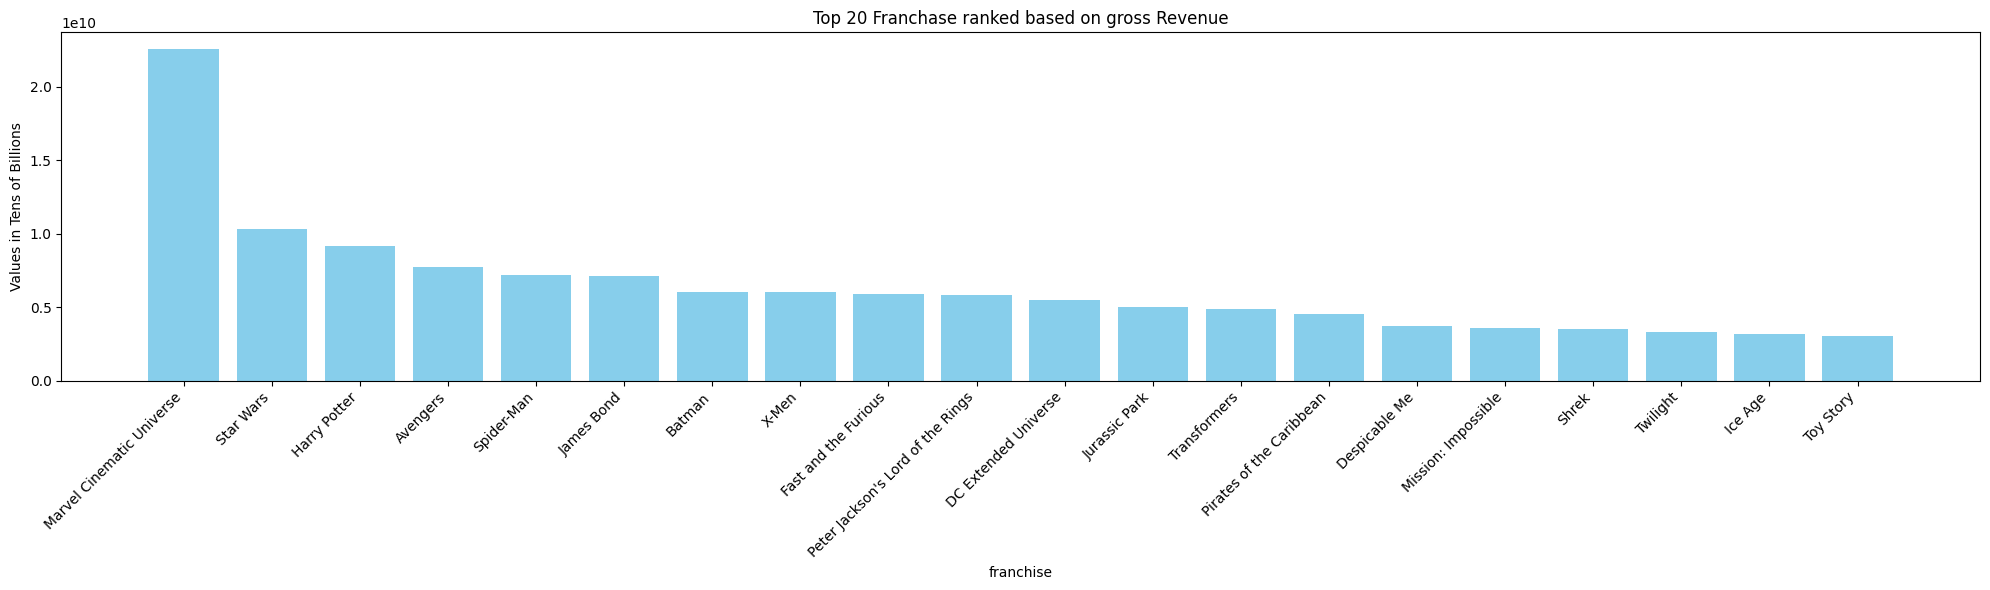

In [66]:
# Process the data
labels = [result[0] for result in results]
values = [result[1] for result in results]

# Create the plot
plt.figure(figsize=(20, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('franchise')
plt.ylabel('Values in Tens of Billions')
plt.title('Top 20 Franchase ranked based on gross Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Ranking Franchise based on the number of Movies Released

In [7]:
cursor.execute("SELECT franchise, No_of_Movies FROM Domestic_Box_Office_Franchises order by 2 DESC LIMIT 20")
results = cursor.fetchall()

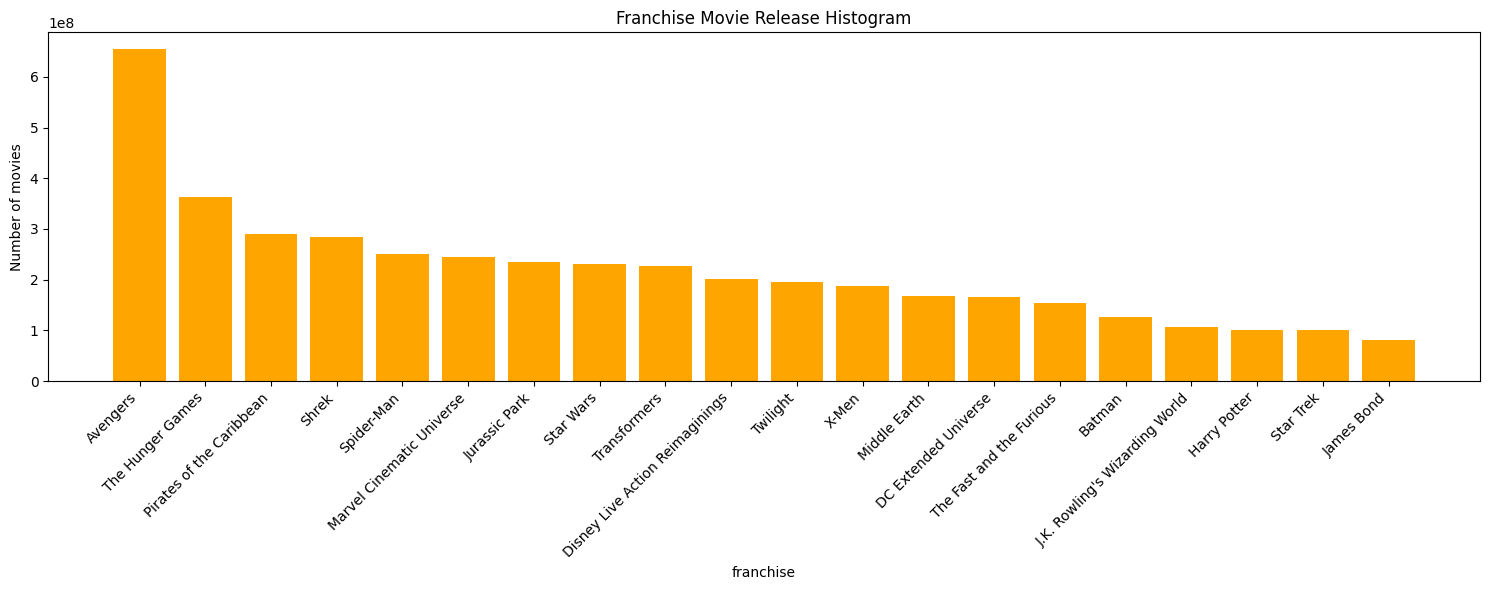

In [13]:
# Process the data
labels = [result[0] for result in results]
values = [result[1] for result in results]

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(labels, values, color='orange')
plt.xlabel('franchise')
plt.ylabel('Number of movies')
plt.title('Franchise Movie Release Histogram')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Franchise average revenue per movie

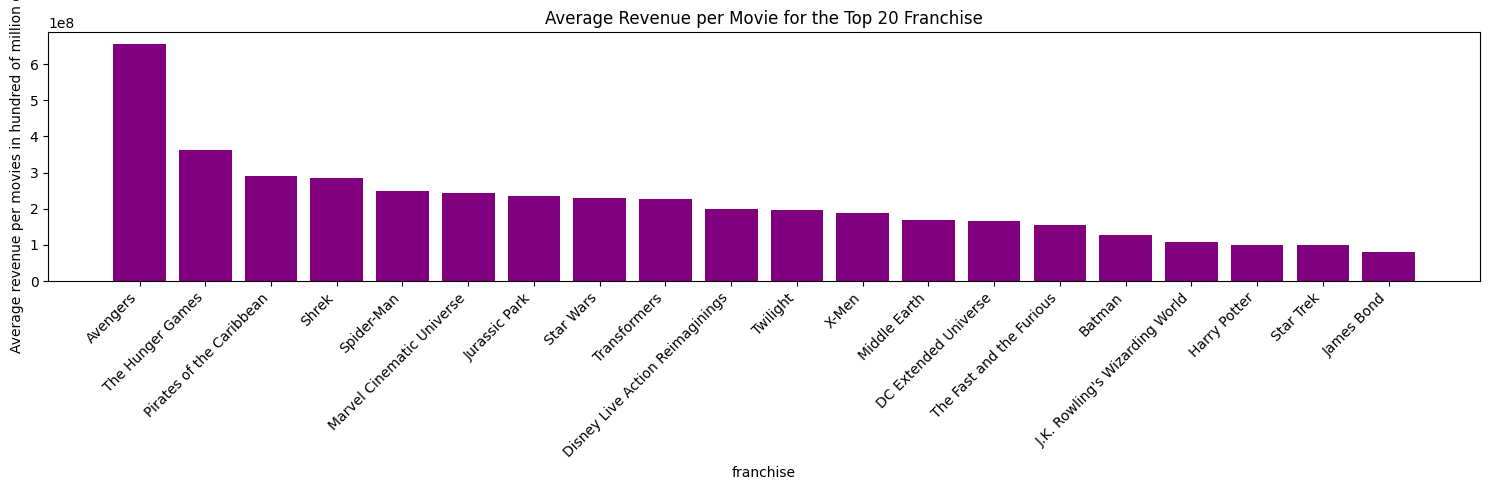

In [7]:
cursor.execute('''SELECT
        Franchise,
        (Total/numbers_of_Movies) as AVG_Revenue_per_Movies
    FROM (
        SELECT
            Franchise,
            SUM(CAST(REPLACE(REPLACE(Lifetime_Gross, '$', ''), ',', '') AS INTEGER)) as Total,
            COUNT(*) as numbers_of_Movies
        FROM
            top_20_for_each_Franchise
        GROUP BY
            Franchise
    )
    ORDER BY
        AVG_Revenue_per_Movies DESC
    LIMIT
        20''')
results = cursor.fetchall()
# Process the data
labels = [result[0] for result in results]
values = [result[1] for result in results]

# Create the plot
plt.figure(figsize=(15, 5))
plt.bar(labels, values, color='purple')
plt.xlabel('franchise')
plt.ylabel('Average revenue per movies in hundred of million dollar')
plt.title('Average Revenue per Movie for the Top 20 Franchise')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


# This query shows that amongst the top 20 movies by gross revenue, 22 of them were released in spring, 17 during summer, 2 in fall, and lastly, 9 out of the 20 were released in winter

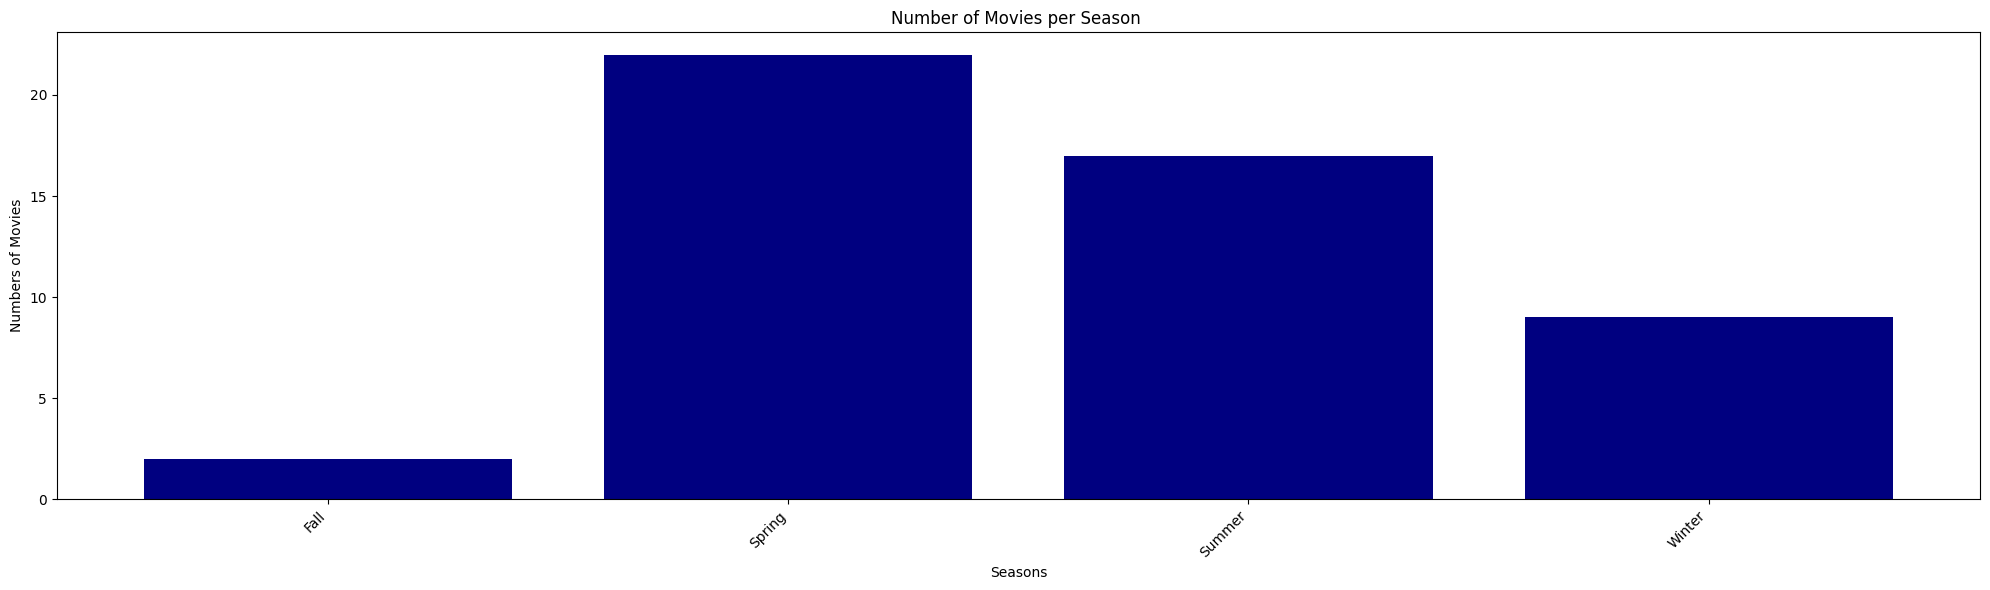

In [40]:

cursor.execute('''
    SELECT
        Count(*) as Number_of_Release_per_season,
        Released_season
    FROM (
        SELECT
            Franchise,
            Release,
            CAST(REPLACE(REPLACE(Lifetime_Gross, '$', ''), ',', '') AS INTEGER) as Total_Gross,
            Release_Date,
            CASE
                WHEN Release_Date LIKE '%Dec%' OR Release_Date LIKE '%Jan%' OR Release_Date LIKE '%Feb%' THEN 'Winter'
                WHEN Release_Date LIKE '%Mar%' OR Release_Date LIKE '%Apr%' OR Release_Date LIKE '%May%' THEN 'Spring'
                WHEN Release_Date LIKE '%Jun%' OR Release_Date LIKE '%Jul%' OR Release_Date LIKE '%Aug%' THEN 'Summer'
                ELSE 'Fall'
            END AS Released_season
        FROM
            top_20_for_each_Franchise
        ORDER BY
            3 DESC
        LIMIT 50
    )
    GROUP BY
        Released_season
''')
results = cursor.fetchall()
# Process the data
labels = [result[1] for result in results]
values = [result[0] for result in results]

# Create the plot
plt.figure(figsize=(20, 6))
plt.bar(labels, values, color='Navy')
plt.xlabel('Seasons')
plt.ylabel('Numbers of Movies')
plt.title('Number of Top Movies per Season ')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


# Impact of production budgets on box office performance.

We only have The Marvel Cinematic Universe Franchise Production budget for each movies.

In [11]:
#p = pd.read_sql('''SELECT * FROM Domestic_Box_Office_Franchises_Marvel_Cinematic''', conn)
p = pd.read_sql('''
    SELECT W_1000.title, Rank world_rank_by_revenue, CAST(REPLACE(REPLACE(Production_Budget, '$', ''), ',', '') AS INTEGER) as Production_Budget, Worldwide_Box_office
    FROM World_Wide_Box_Office_All_Time_Top_1000 W_1000
    JOIN
    Domestic_Box_Office_Franchises_Marvel_Cinematic D_Marvel
    ON W_1000.title = D_Marvel.title
    ORDER BY Worldwide_Box_Office, CAST(REPLACE(REPLACE(production_budget, '$', ''), ',', '') AS INTEGER) DESC
    ''', conn)

display(p)


,Title,world_rank_by_revenue,Production_Budget,Worldwide_Box_Office
0,Captain Marvel,26,175000000,"$1,129,729,839"
1,Captain America: Civil War,22,250000000,"$1,153,284,349"
2,Iron Man 3,20,200000000,"$1,215,392,272"
3,Black Panther,12,200000000,"$1,346,913,161"
4,Avengers: Age of Ultron,11,365000000,"$1,403,013,963"
5,The Avengers,8,225000000,"$1,518,812,988"
6,Avengers: Infinity War,5,300000000,"$2,048,359,754"
7,Avengers: Endgame,1,400000000,"$2,797,800,564"
8,The Incredible Hulk,569,137500000,"$265,573,859"
9,Captain America: The First Avenger,347,140000000,"$370,569,776"


Correlation coefficient: -0.5693364247265823


# Correlation Between Production Budget and Movie Success
We Could see that we have a negative moderate correlation, which suggests that  the higher the production budget the more successful in ranking the movie can become, based on the Marvel Cinetmatic Universe Franchise.

In [12]:
correlation = p['world_rank_by_revenue'].corr(p['Production_Budget'])
print("Correlation coefficient:", correlation)

Correlation coefficient: -0.5693364247265823
